## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_L1_mlp(input_shape,output_units=10,num_neurons=[512,256,128],l1_ratio=1e-4):
    input_layer=keras.layers.Input(input_shape)
    for i,num in enumerate(num_neurons):
        if i==0:
            x=keras.layers.Dense(units=num,activation='relu',name='hidden_layer'+str(i+1),kernel_regularizer=l1(l1_ratio))(input_layer)
        else :
            x=keras.layers.Dense(units=num,activation='relu',name='hidden_layer'+str(i+1),kernel_regularizer=l1(l1_ratio))(x)
        
    out=keras.layers.Dense(units=output_units,activation='softmax',name='output_layer')(x)    
    model=keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_L2_mlp(input_shape,output_units=10,num_neurons=[512,256,128],l2_ratio=1e-4):
    input_layer=keras.layers.Input(input_shape)
    for i,num in enumerate(num_neurons):
        if i==0:
            x=keras.layers.Dense(units=num,activation='relu',name='hidden_layer'+str(i+1),kernel_regularizer=l2(l2_ratio))(input_layer)
        else :
            x=keras.layers.Dense(units=num,activation='relu',name='hidden_layer'+str(i+1),kernel_regularizer=l2(l2_ratio))(x)
        
    out=keras.layers.Dense(units=output_units,activation='softmax',name='output_layer')(x)    
    model=keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_L1_L2_mlp(input_shape,output_units=10,num_neurons=[512,256,128],l1_ratio=1e-4,l2_ratio=1e-4):
    input_layer=keras.layers.Input(input_shape)
    for i,num in enumerate(num_neurons):
        if i==0:
            x=keras.layers.Dense(units=num,activation='relu',name='hidden_layer'+str(i+1),kernel_regularizer=l1_l2(l1=l1_ratio,l2=l2_ratio))(input_layer)
        else :
            x=keras.layers.Dense(units=num,activation='relu',name='hidden_layer'+str(i+1),kernel_regularizer=l1_l2(l1=l1_ratio,l2=l2_ratio))(x)
        
    out=keras.layers.Dense(units=output_units,activation='softmax',name='output_layer')(x)    
    model=keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
EPOCHS=50
LR=0.01
BATCH_SIZE = 256
L_EXP=[1e-2,1e-4,1e-8]

REGULARIZERS=['l1','l2','l1l2']

In [7]:
for i, l in enumerate(REGULARIZERS):
    print(i,l)

0 l1
1 l2
2 l1l2


In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, l in enumerate(REGULARIZERS):
    for r1 in L_EXP :
        keras.backend.clear_session() # 把舊的 Graph 清掉
        
        if i==0 :
            print(f"Experiment with {l} Regulizer and ratio = {r1}")
            model = build_L1_mlp(input_shape=x_train.shape[1:], l1_ratio=r1)
        if i==1 :
            print(f"Experiment with {l} Regulizer and ratio = {r1}")
            model = build_L2_mlp(input_shape=x_train.shape[1:], l2_ratio=r1)
        if i==2 :
            print(f"Experiment with {l} Regulizer and ratio = {r1}")
            model = build_L1_L2_mlp(input_shape=x_train.shape[1:],l1_ratio=r1,l2_ratio=r1)

        model.summary()
        optimizer=keras.optimizers.Adam(lr=LR)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train,y_train,epochs=EPOCHS,validation_data=[x_test,y_test],batch_size=256,shuffle=True)
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        
        exp_name_tag = f"exp-{l}-{r1}"
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with l1 Regulizer and ratio = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 45us/step - loss: 8.9900 - acc: 0.0992 - val_loss: 3.2853 - val_acc: 0.1000
Epoch 2/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.7056 - acc: 0.1059 - val_loss: 2.8548 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 33us/step - loss: 2.7204 - acc: 0.1052 - val_loss: 2.9675 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.6661 - acc: 0.1069 - val_loss: 2.5374 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 3.3192 - acc: 0.1063 - val_loss: 3.0983 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 2.6040 - acc: 0.0988 - val_loss: 2.5213 - val_acc: 0.1032
Epoch 7/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.5823 - acc: 0.1043 - val_loss: 2.5554 - val_acc

50000/50000 [==============================] - 2s 31us/step - loss: 14.5071 - acc: 0.1000 - val_loss: 14.5071 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 2s 32us/step - loss: 14.5071 - acc: 0.1000 - val_loss: 14.5071 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 14.5071 - acc: 0.1000 - val_loss: 14.5071 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 31us/step - loss: 14.5071 - acc: 0.1000 - val_loss: 14.5071 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 30us/step - loss: 14.5070 - acc: 0.1000 - val_loss: 14.5070 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 30us/step - loss: 14.5070 - acc: 0.1000 - val_loss: 14.5070 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 30us/step - loss: 14.5070 - acc: 0.1000 - val_loss: 14.5070 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============

50000/50000 [==============================] - 2s 32us/step - loss: 2.3728 - acc: 0.1207 - val_loss: 2.3560 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.3552 - acc: 0.1173 - val_loss: 2.3201 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.3066 - acc: 0.0979 - val_loss: 2.3036 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 2.3038 - acc: 0.0980 - val_loss: 2.3040 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.3035 - acc: 0.0981 - val_loss: 2.3032 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.3033 - acc: 0.0994 - val_loss: 2.3030 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.3033 - acc: 0.0987 - val_loss: 2.3030 - val_acc: 0.1000
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 2s 31us/step - loss: 2.1028 - acc: 0.2081 - val_loss: 2.1144 - val_acc: 0.2253
Epoch 5/50
50000/50000 [==============================] - 2s 31us/step - loss: 2.0018 - acc: 0.2591 - val_loss: 2.0089 - val_acc: 0.2521
Epoch 6/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.9553 - acc: 0.2751 - val_loss: 1.9422 - val_acc: 0.2728
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.9353 - acc: 0.2896 - val_loss: 1.9124 - val_acc: 0.2990
Epoch 8/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8942 - acc: 0.3094 - val_loss: 1.9103 - val_acc: 0.3089
Epoch 9/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.8857 - acc: 0.3138 - val_loss: 1.8527 - val_acc: 0.3243
Epoch 10/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.8803 - acc: 0.3156 - val_loss: 1.8591 - val_acc: 0.3272
Epoch 11/50
50000/50000 [==========================

50000/50000 [==============================] - 1s 29us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 32us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 31us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 31us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 1s 30us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 2s 33us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [===========

Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 24.5416 - acc: 0.0982 - val_loss: 25.2172 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 34us/step - loss: 24.5328 - acc: 0.0985 - val_loss: 25.1007 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 31us/step - loss: 24.5441 - acc: 0.0995 - val_loss: 24.3821 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 32us/step - loss: 24.5422 - acc: 0.0969 - val_loss: 25.4546 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 33us/step - loss: 24.5361 - acc: 0.0983 - val_loss: 26.2625 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 2s 31us/step - loss: 24.5474 - acc: 0.0993 - val_loss: 24.5278 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 2s 34us/step - loss: 24.5408 - acc: 0.0982 - val_loss: 24.2351 - val_acc: 0.1000
Epoch 13/50
50000/50000 

Epoch 7/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.6938 - acc: 0.1041 - val_loss: 2.4732 - val_acc: 0.0997
Epoch 8/50
50000/50000 [==============================] - 2s 34us/step - loss: 3.6213 - acc: 0.1143 - val_loss: 3.7671 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 37us/step - loss: 2.8037 - acc: 0.1044 - val_loss: 2.5556 - val_acc: 0.1637
Epoch 10/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.6095 - acc: 0.1088 - val_loss: 2.5584 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 2s 32us/step - loss: 2.5678 - acc: 0.1096 - val_loss: 2.5482 - val_acc: 0.1001
Epoch 12/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.5564 - acc: 0.1285 - val_loss: 2.6983 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==============================] - 2s 33us/step - loss: 2.5523 - acc: 0.0990 - val_loss: 2.5293 - val_acc: 0.1000
Epoch 14/50
50000/50000 [============

50000/50000 [==============================] - 2s 34us/step - loss: 14.5070 - acc: 0.1000 - val_loss: 14.5070 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 34us/step - loss: 14.5070 - acc: 0.1000 - val_loss: 14.5070 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 34us/step - loss: 14.5070 - acc: 0.1000 - val_loss: 14.5070 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 2s 34us/step - loss: 14.5070 - acc: 0.1000 - val_loss: 14.5070 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 2s 37us/step - loss: 14.5069 - acc: 0.1000 - val_loss: 14.5069 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==============================] - 2s 35us/step - loss: 14.5069 - acc: 0.1000 - val_loss: 14.5069 - val_acc: 0.1000
Epoch 14/50
50000/50000 [==============================] - 2s 39us/step - loss: 14.5069 - acc: 0.1000 - val_loss: 14.5069 - val_acc: 0.1000
Epoch 15/50
50000/50000 [========

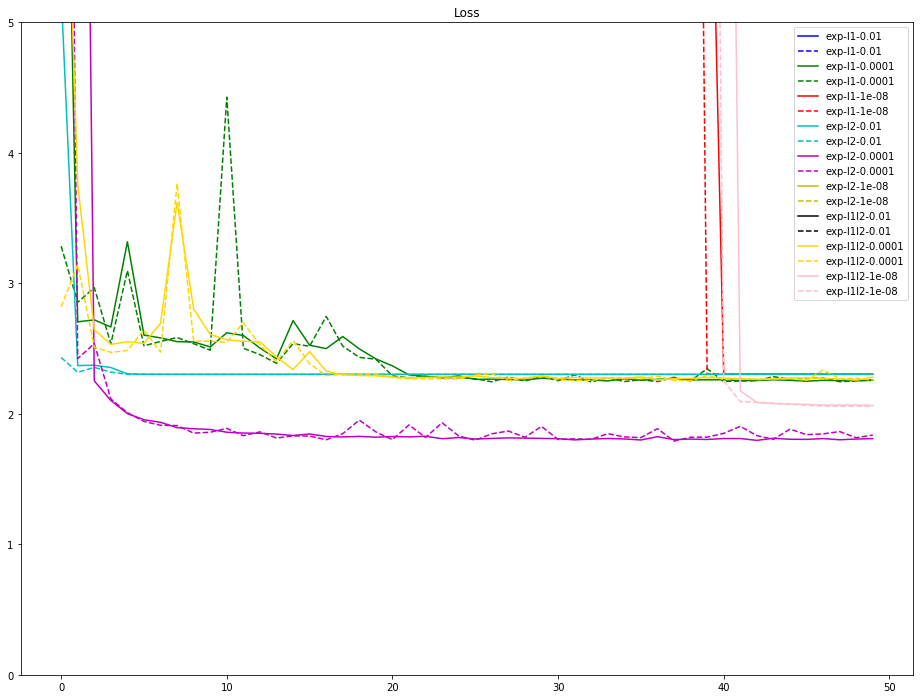

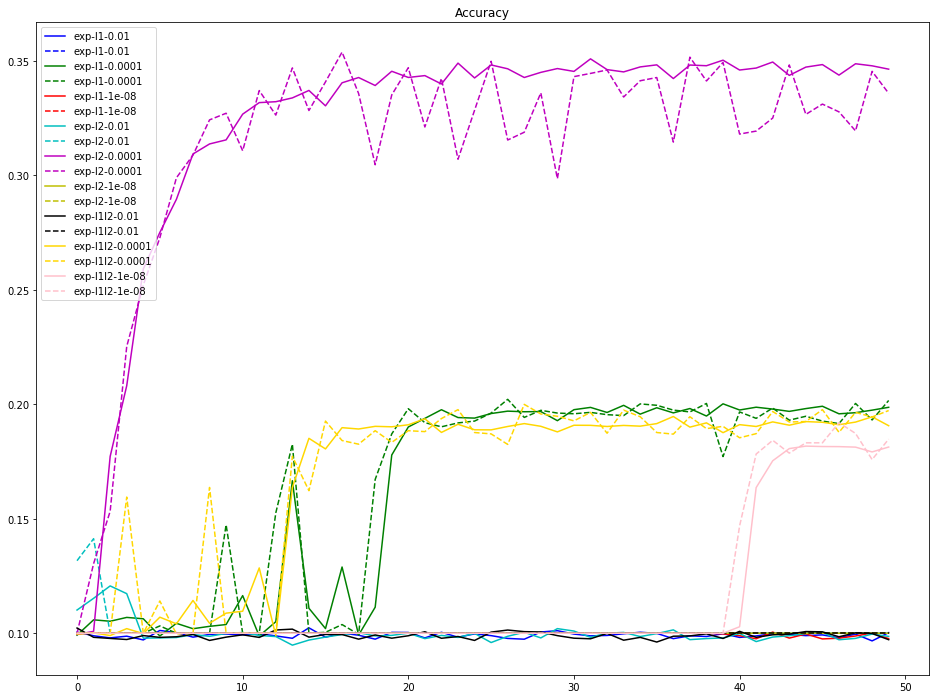

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gold',"pink","skyblue","aqua","purple","deeppink","aqua"]
plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()